In [12]:
import os
os.environ["JAVA_HOME"] = "C:\\Program Files\\Java\\jdk-21"  # Update with your Java version
os.environ["PATH"] = os.environ["JAVA_HOME"] + "\\bin;" + os.environ["PATH"]


In [13]:
from pyspark.sql import SparkSession 
from pyspark.sql.functions import col,log1p,sqrt,expr, to_timestamp, skewness, kurtosis, lag, when
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.window import Window
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [103]:
spark = SparkSession.builder.appName('anamoly_detection_using_spark') \
.config("spark.driver.memory", "8g") \
.config("spark.executor.memory", "8g") \
.config("spark.sql.execution.arrow.enabled", "true") \
.getOrCreate()
# spark.conf.set("spark.sql.execution.arrow.enabled", "true")
df= spark.read.csv('burke-gilman-trail-north-of-ne-70th-st-bike-and-ped-counter (4).csv',header=True)

In [104]:

df = df.withColumn('Date', to_timestamp(col('Date')))
df.show()

+-------------------+--------------------------+---------+---------+----------+----------+
|               Date|BGT North of NE 70th Total|Ped South|Ped North|Bike North|Bike South|
+-------------------+--------------------------+---------+---------+----------+----------+
|2014-01-01 00:00:00|                        15|        0|        2|         2|        11|
|2014-01-01 01:00:00|                         9|        1|        0|         1|         7|
|2014-01-01 02:00:00|                         9|        0|        0|         0|         9|
|2014-01-01 03:00:00|                        19|        0|        0|         0|        19|
|2014-01-01 04:00:00|                        19|        0|        0|         0|        19|
|2014-01-01 05:00:00|                        14|        0|        0|         0|        14|
|2014-01-01 06:00:00|                        10|        0|        1|         1|         8|
|2014-01-01 07:00:00|                        10|        2|        3|         4|         1|

# Data type conversion

In [105]:
columns = ['Ped South', 'Ped North', 'Bike South', 'Bike North']

for col_name in columns:
    df = df.withColumn(col_name,col(col_name).cast('double'))

# Filling null values

In [106]:
columns = ['Ped South', 'Ped North', 'Bike South', 'Bike North']

for col_name in columns:
    median_value = df.approxQuantile(col_name,[0.5], 0.01)[0]
    df = df.fillna({col_name:median_value})


# Recalculate 'BGT North of NE 70th Total' as sum of other columns
df = df.withColumn("BGT North of NE 70th Total",
                   col("Ped South") + col("Ped North") + col("Bike South") + col("Bike North"))


df.show(10)

+-------------------+--------------------------+---------+---------+----------+----------+
|               Date|BGT North of NE 70th Total|Ped South|Ped North|Bike North|Bike South|
+-------------------+--------------------------+---------+---------+----------+----------+
|2014-01-01 00:00:00|                      15.0|      0.0|      2.0|       2.0|      11.0|
|2014-01-01 01:00:00|                       9.0|      1.0|      0.0|       1.0|       7.0|
|2014-01-01 02:00:00|                       9.0|      0.0|      0.0|       0.0|       9.0|
|2014-01-01 03:00:00|                      19.0|      0.0|      0.0|       0.0|      19.0|
|2014-01-01 04:00:00|                      19.0|      0.0|      0.0|       0.0|      19.0|
|2014-01-01 05:00:00|                      14.0|      0.0|      0.0|       0.0|      14.0|
|2014-01-01 06:00:00|                      10.0|      0.0|      1.0|       1.0|       8.0|
|2014-01-01 07:00:00|                      10.0|      2.0|      3.0|       4.0|       1.0|

In [8]:
df.show()

+-------------------+--------------------------+---------+---------+----------+----------+
|               Date|BGT North of NE 70th Total|Ped South|Ped North|Bike North|Bike South|
+-------------------+--------------------------+---------+---------+----------+----------+
|2014-01-01 00:00:00|                      15.0|      0.0|      2.0|       2.0|      11.0|
|2014-01-01 01:00:00|                       9.0|      1.0|      0.0|       1.0|       7.0|
|2014-01-01 02:00:00|                       9.0|      0.0|      0.0|       0.0|       9.0|
|2014-01-01 03:00:00|                      19.0|      0.0|      0.0|       0.0|      19.0|
|2014-01-01 04:00:00|                      19.0|      0.0|      0.0|       0.0|      19.0|
|2014-01-01 05:00:00|                      14.0|      0.0|      0.0|       0.0|      14.0|
|2014-01-01 06:00:00|                      10.0|      0.0|      1.0|       1.0|       8.0|
|2014-01-01 07:00:00|                      10.0|      2.0|      3.0|       4.0|       1.0|

# Adding target column

In [107]:
window_spec = Window().orderBy('Date')
#setting target feature
df = df.withColumn("Anomaly", when(col("BGT North of NE 70th Total") >= 500, 1).otherwise(0))
df = df.withColumn("Anomaly_3hr_Ahead", lag("Anomaly", -3).over(window_spec))

In [108]:
# Compute Summary Statistics
summary_stat = df.describe()
summary_stat.show()

+-------+--------------------------+------------------+------------------+------------------+-----------------+--------------------+--------------------+
|summary|BGT North of NE 70th Total|         Ped South|         Ped North|        Bike North|       Bike South|             Anomaly|   Anomaly_3hr_Ahead|
+-------+--------------------------+------------------+------------------+------------------+-----------------+--------------------+--------------------+
|  count|                     52584|             52584|             52584|             52584|            52584|               52584|               52581|
|   mean|         71.81901338810285|19.641487905066178|  9.56891830214514|21.231268066331964|21.37733911455956|0.009432527004411988|0.009433065175633784|
| stddev|        187.81586738317858|132.90530737258584|40.713128071069825|32.668014651585224|61.25083457766319|  0.0966629822127716|  0.0966657135118246|
|    min|                       0.0|               0.0|               0.0|  

In [109]:

# Compute Skewness & Kurtosis
skewness_df  = df.select(
    skewness(col("BGT North of NE 70th Total")).alias("BGT North of NE 70th Total"),
    skewness(col('Ped South')).alias('Ped South'),
    skewness(col('Ped North')).alias('Ped North'),
    skewness(col('Bike South')).alias('Bike South'),
    skewness(col('Bike North')).alias('Bike North'),
    # kurtosis(col("BGT North of NE 70th Total")).alias("kurtosis")
).show()



+--------------------------+------------------+----------------+-----------------+------------------+
|BGT North of NE 70th Total|         Ped South|       Ped North|       Bike South|        Bike North|
+--------------------------+------------------+----------------+-----------------+------------------+
|        15.379001270982352|13.533858768190937|34.6978752720907|96.23681914118107|3.6588230632740046|
+--------------------------+------------------+----------------+-----------------+------------------+



In [110]:
# Compute Kurtosis
kurtosis_df = df.select(
    kurtosis(col('BGT North of NE 70th Total')).alias('BGT North of NE 70th Total'),
    kurtosis(col('Ped South')).alias('Ped South'),
    kurtosis(col('Ped North')).alias('Ped North'),
    kurtosis(col('Bike South')).alias('Bike South'),
    kurtosis(col('Bike North')).alias('Bike North')
).show()



+--------------------------+------------------+-----------------+------------------+-----------------+
|BGT North of NE 70th Total|         Ped South|        Ped North|        Bike South|       Bike North|
+--------------------------+------------------+-----------------+------------------+-----------------+
|         470.2432004263731|210.74836960311225|2303.585144564282|12409.412551529564|36.69746248680579|
+--------------------------+------------------+-----------------+------------------+-----------------+



In [111]:
# using log transformation 
df = df.withColumn('BGT North of NE 70th Total', log1p(df['BGT North of NE 70th Total']))
df = df.withColumn('Ped South', log1p(df['Ped South']))
df = df.withColumn('Bike North', log1p(df['Bike North']))

#using square root transformation
df = df.withColumn('Ped North', sqrt(df['Ped North']))

#using Winsorization transformation

#compute percentile
percentile_99 = df.approxQuantile('Bike South',[0.97],0.01)[0]
print(percentile_99)
# Apply capping (Winsorization)
df = df.withColumn('Bike South', expr(f"CASE WHEN `Bike South` > {float(percentile_99)} THEN {float(percentile_99)} ELSE `Bike South` END"))




91.0


# Lag features

In [112]:
#create lag feature
df = df.withColumn('Lag_1_day',lag("BGT North of NE 70th Total", 1).over(window_spec))
df = df.withColumn('Lag_2_day',lag("BGT North of NE 70th Total", 2).over(window_spec))
df = df.withColumn('Lag_3_day',lag("BGT North of NE 70th Total", 3).over(window_spec))

In [113]:
df.show()

+-------------------+--------------------------+------------------+------------------+------------------+----------+-------+-----------------+------------------+------------------+------------------+
|               Date|BGT North of NE 70th Total|         Ped South|         Ped North|        Bike North|Bike South|Anomaly|Anomaly_3hr_Ahead|         Lag_1_day|         Lag_2_day|         Lag_3_day|
+-------------------+--------------------------+------------------+------------------+------------------+----------+-------+-----------------+------------------+------------------+------------------+
|2014-01-01 00:00:00|         2.772588722239781|               0.0|1.4142135623730951|1.0986122886681096|      11.0|      0|                0|              NULL|              NULL|              NULL|
|2014-01-01 01:00:00|         2.302585092994046|0.6931471805599453|               0.0|0.6931471805599453|       7.0|      0|                0| 2.772588722239781|              NULL|              NULL|


In [114]:
from pyspark.sql.functions import avg, stddev

window_spec = Window().orderBy("Date").rowsBetween(-3, 0)  # Last 3 hours

df = df.withColumn("Rolling_Mean_3H", avg("BGT North of NE 70th Total").over(window_spec))
df = df.withColumn("Rolling_Std_3H", stddev("BGT North of NE 70th Total").over(window_spec))

In [18]:
df.show()

+-------------------+--------------------------+------------------+------------------+------------------+----------+-------+-----------------+------------------+------------------+------------------+------------------+-------------------+
|               Date|BGT North of NE 70th Total|         Ped South|         Ped North|        Bike North|Bike South|Anomaly|Anomaly_3hr_Ahead|         Lag_1_day|         Lag_2_day|         Lag_3_day|   Rolling_Mean_3H|     Rolling_Std_3H|
+-------------------+--------------------------+------------------+------------------+------------------+----------+-------+-----------------+------------------+------------------+------------------+------------------+-------------------+
|2014-01-01 00:00:00|         1.327761429538331|               0.0| 1.189207115002721|0.7412763113750152|      11.0|      0|                0|              NULL|              NULL|              NULL| 1.327761429538331|               NULL|
|2014-01-01 01:00:00|        1.1947055233182

In [26]:

df.summary().show()  # Check if there are NULL values


+-------+--------------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+-------------------+
|summary|BGT North of NE 70th Total|         Ped South|         Ped North|        Bike North|        Bike South|             Anomaly|   Anomaly_3hr_Ahead|         Lag_1_day|         Lag_2_day|         Lag_3_day|   Rolling_Mean_3H|     Rolling_Std_3H|
+-------+--------------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+-------------------+
|  count|                     52584|             52584|             52584|             52584|             52584|               52584|               52581|             52583|             52582|             52581|             52584|              525

In [115]:
df = df.withColumn("Bike_Ped_Ratio", col("Bike North") / (col("Ped North") + 1))
df = df.fillna(0)  # Replace all NULLs with 0



In [116]:
df.groupBy("Anomaly_3hr_Ahead").count().show()

df.show()

+-----------------+-----+
|Anomaly_3hr_Ahead|count|
+-----------------+-----+
|                0|52088|
|                1|  496|
+-----------------+-----+

+-------------------+--------------------------+------------------+------------------+------------------+----------+-------+-----------------+------------------+------------------+------------------+------------------+-------------------+-------------------+
|               Date|BGT North of NE 70th Total|         Ped South|         Ped North|        Bike North|Bike South|Anomaly|Anomaly_3hr_Ahead|         Lag_1_day|         Lag_2_day|         Lag_3_day|   Rolling_Mean_3H|     Rolling_Std_3H|     Bike_Ped_Ratio|
+-------------------+--------------------------+------------------+------------------+------------------+----------+-------+-----------------+------------------+------------------+------------------+------------------+-------------------+-------------------+
|2014-01-01 00:00:00|         2.772588722239781|               0.0

In [117]:
from pyspark.sql.functions import col, when

# Compute class weights
total_count = df.count()
class_counts = df.groupBy("Anomaly_3hr_Ahead").count().collect()

# Create a dictionary of class weights
class_weights = {row["Anomaly_3hr_Ahead"]: total_count / row["count"] for row in class_counts}

# Add weight column
df = df.withColumn(
    "class_weight",
    when(col("Anomaly_3hr_Ahead") == 1, class_weights[1]).otherwise(class_weights[0])
)

In [118]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [119]:
columns =  [ 'Anomaly_3hr_Ahead', 'Lag_1_day',         'Lag_2_day',         'Lag_3_day',   'Rolling_Mean_3H',     'Rolling_Std_3H']
for col_name in columns:
    df = df.withColumn(col_name,col(col_name).cast('double'))

In [120]:
col = df.columns
print(col)

['Date', 'BGT North of NE 70th Total', 'Ped South', 'Ped North', 'Bike North', 'Bike South', 'Anomaly', 'Anomaly_3hr_Ahead', 'Lag_1_day', 'Lag_2_day', 'Lag_3_day', 'Rolling_Mean_3H', 'Rolling_Std_3H', 'Bike_Ped_Ratio', 'class_weight']


In [26]:
df.show()

+-------------------+--------------------------+------------------+------------------+------------------+----------+-------+-----------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-----------------+
|               Date|BGT North of NE 70th Total|         Ped South|         Ped North|        Bike North|Bike South|Anomaly|Anomaly_3hr_Ahead|         Lag_1_day|         Lag_2_day|         Lag_3_day|   Rolling_Mean_3H|     Rolling_Std_3H|     Bike_Ped_Ratio|     class_weight|
+-------------------+--------------------------+------------------+------------------+------------------+----------+-------+-----------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-----------------+
|2014-01-01 00:00:00|         1.327761429538331|               0.0| 1.189207115002721|0.7412763113750152|      11.0|      0|              0.0|               0.0|        

In [121]:
from pyspark.sql.functions import col, sum, when

# Count nulls for each column
null_counts = df.select(
        [sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns]
    )
    
    # Show the result
null_counts.show()

from pyspark.sql.functions import col

# Check if there are nulls in the entire DataFrame
df.describe().show()  # This gives summary statistics
df.summary().show()  # More detailed stats

    

+----+--------------------------+---------+---------+----------+----------+-------+-----------------+---------+---------+---------+---------------+--------------+--------------+------------+
|Date|BGT North of NE 70th Total|Ped South|Ped North|Bike North|Bike South|Anomaly|Anomaly_3hr_Ahead|Lag_1_day|Lag_2_day|Lag_3_day|Rolling_Mean_3H|Rolling_Std_3H|Bike_Ped_Ratio|class_weight|
+----+--------------------------+---------+---------+----------+----------+-------+-----------------+---------+---------+---------+---------------+--------------+--------------+------------+
|   0|                         0|        0|        0|         0|         0|      0|                0|        0|        0|        0|              0|             0|             0|           0|
+----+--------------------------+---------+---------+----------+----------+-------+-----------------+---------+---------+---------+---------------+--------------+--------------+------------+

+-------+--------------------------+--------

In [122]:
from pyspark.sql.functions import hour, dayofweek, month

df = df.withColumn("Hour", hour("Date"))
df = df.withColumn("DayOfWeek", dayofweek("Date"))
df = df.withColumn("Month", month("Date"))


# EDA 

In [123]:
from pyspark.sql.functions import col, hour,dayofweek, month, weekofyear, avg, when, stddev, mean
from pyspark.sql.window import Window

#compute weeks of year
df = df.withColumn('Week of year', weekofyear('Date'))

#compute hourly traffic trend
hourly_traffic = df.groupBy('Hour').agg(avg('BGT North of NE 70th Total').alias('average hourly traffic'))

#compute day of week traffic trend
weekly_traffic = df.groupBy("DayOfWeek").agg(avg("BGT North of NE 70th Total").alias("Avg_Traffic"))

# compute monthly traffic average
monthly_traffic = df.groupBy('Month').agg(avg('BGT North of NE 70th Total').alias('average momthly traffic trend'))

#compute weeks of year traffic trend
week_year_traffic = df.groupBy('Week of year').agg(avg('BGT North of NE 70th Total').alias('average weeks of year traffic trend'))



In [124]:
print(weekly_traffic,monthly_traffic,hourly_traffic)
# weekly_traffic.show()
# monthly_traffic.show()
hourly_traffic.show()

DataFrame[DayOfWeek: int, Avg_Traffic: double] DataFrame[Month: int, average momthly traffic trend: double] DataFrame[Hour: int, average hourly traffic: double]
+----+----------------------+
|Hour|average hourly traffic|
+----+----------------------+
|  12|     4.312052262093978|
|  22|    1.5723374070860288|
|   1|    0.5445643544259441|
|  13|     4.314566616722907|
|   6|     3.312977090064919|
|  16|     4.605380924068011|
|   3|    0.5803882281959689|
|  20|     2.796391459593819|
|   5|     2.301046095158892|
|  19|    3.4685188351360003|
|  15|     4.449245531903663|
|   9|    4.3541667047153325|
|  17|     4.544971291138357|
|   4|    1.3098592718114497|
|   8|     4.384738261906119|
|  23|    1.1130467358469607|
|   7|     4.028916289621279|
|  10|     4.303854154631774|
|  21|     2.159241153522885|
|  11|      4.29659043272963|
+----+----------------------+
only showing top 20 rows



In [125]:
# Compute Rolling Averages
window_spec = Window.orderBy("Date").rowsBetween(-6, 0)
df = df.withColumn("Rolling_7Day_Avg", avg("BGT North of NE 70th Total").over(window_spec))

#  Detect Anomalies Using Z-Score
traffic_stats = df.select(
    mean(col("BGT North of NE 70th Total")).alias("Mean_Traffic"),
    stddev(col("BGT North of NE 70th Total")).alias("StdDev_Traffic")
).collect()

mean_traffic = traffic_stats[0]["Mean_Traffic"]
stddev_traffic = traffic_stats[0]["StdDev_Traffic"]

df = df.withColumn("Z-Score", (col("BGT North of NE 70th Total") - mean_traffic) / stddev_traffic)


In [128]:
df = df.withColumn('final_target_column',col('final_target_column').cast('double'))

In [127]:
from pyspark.sql.functions import abs, col, when

df = df.withColumn("z-score_anomaly", when(abs(col("Z-Score")) > 2, 1).otherwise(0))
df = df.withColumn('final_target_column',  lag("z-score_anomaly", -3).over(Window.orderBy("Date")))
# Show results
df.show(10)


+-------------------+--------------------------+------------------+------------------+------------------+----------+-------+-----------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-----------------+----+---------+-----+------------+------------------+--------------------+---------------+-------------------+
|               Date|BGT North of NE 70th Total|         Ped South|         Ped North|        Bike North|Bike South|Anomaly|Anomaly_3hr_Ahead|         Lag_1_day|         Lag_2_day|         Lag_3_day|   Rolling_Mean_3H|     Rolling_Std_3H|     Bike_Ped_Ratio|     class_weight|Hour|DayOfWeek|Month|Week of year|  Rolling_7Day_Avg|             Z-Score|z-score_anomaly|final_target_column|
+-------------------+--------------------------+------------------+------------------+------------------+----------+-------+-----------------+------------------+------------------+------------------+------------------+--------

In [129]:
df.select("final_target_column").summary().show()
df = df.na.drop(subset=["final_target_column"])
df = df.na.fill({"final_target_column": 0})  # Assuming 0 means "not anomaly"


+-------+--------------------+
|summary| final_target_column|
+-------+--------------------+
|  count|               52581|
|   mean|0.007550255795819783|
| stddev|  0.0865643803457163|
|    min|                 0.0|
|    25%|                 0.0|
|    50%|                 0.0|
|    75%|                 0.0|
|    max|                 1.0|
+-------+--------------------+



In [130]:
df.dropna()
df.show()

+-------------------+--------------------------+------------------+------------------+------------------+----------+-------+-----------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-----------------+----+---------+-----+------------+------------------+--------------------+---------------+-------------------+
|               Date|BGT North of NE 70th Total|         Ped South|         Ped North|        Bike North|Bike South|Anomaly|Anomaly_3hr_Ahead|         Lag_1_day|         Lag_2_day|         Lag_3_day|   Rolling_Mean_3H|     Rolling_Std_3H|     Bike_Ped_Ratio|     class_weight|Hour|DayOfWeek|Month|Week of year|  Rolling_7Day_Avg|             Z-Score|z-score_anomaly|final_target_column|
+-------------------+--------------------------+------------------+------------------+------------------+----------+-------+-----------------+------------------+------------------+------------------+------------------+--------

In [132]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Convert to Pandas DataFrame
pandas_df = df.toPandas()

# Separate features and target
X = pandas_df.drop("final_target_column", axis=1)
y = pandas_df["final_target_column"]

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine back into a DataFrame
resampled_df = pd.concat([pd.DataFrame(X_resampled), pd.Series(y_resampled, name="final_target_column")], axis=1)

# Convert back to PySpark DataFrame
df = spark.createDataFrame(resampled_df)

AttributeError: 'DataFrame' object has no attribute '_get_object_id'

In [ ]:
majority_df = df.filter(col("final_target_column") == 0)
minority_df = df.filter(col("final_target_column") == 1)

sampled_majority_df = majority_df.sample(False, fraction=minority_df.count() / majority_df.count())

balanced_df = sampled_majority_df.union(minority_df)

In [97]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Define feature columns
feature_columns = ['Lag_1_day', 'Lag_2_day', 'Lag_3_day', 'Rolling_Mean_3H', 'Rolling_Std_3H','Hour','DayOfWeek','Month','Rolling_7Day_Avg','Z-Score']

# Drop existing feature columns if present
if "features" in df.columns:
    df = df.drop("features")
if "features1" in df.columns:
    df = df.drop("features1")

# Assemble feature columns into a single vector
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features1")
df = vector_assembler.transform(df)

# Split data into training and testing sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
print(f"Training Data Count: {train_df.count()}")
train_df.show()

# Define Random Forest model
# rf = RandomForestClassifier(featuresCol="features1", labelCol="final_target_column", numTrees=100, weightCol="class_weight")

from pyspark.ml.classification import GBTClassifier


# Define GBT model with regularization-like hyperparameters
xgb = GBTClassifier(
    featuresCol="features1",
    labelCol="final_target_column",
    maxIter=100,  # Number of trees
    maxDepth=5,  # Regularization: Limit tree depth
    minInstancesPerNode=10,  # Regularization: Prevent overly specific splits
    subsamplingRate=0.8,  # Regularization: Introduce randomness
    stepSize=0.1,  # Regularization: Shrinkage (learning rate)
    maxBins=32,  # Regularization: Coarsen feature space
    weightCol='class_weight'
)

# Define hyperparameter grid for tuning
paramGrid = ParamGridBuilder() \
    .addGrid(xgb.maxIter, [5, 10]) \
    .addGrid(xgb.maxDepth, [5, 10]) \
    .addGrid(xgb.minInstancesPerNode, [10, 20]) \
    .addGrid(xgb.subsamplingRate, [0.8, 1.0]) \
    .addGrid(xgb.stepSize, [0.1, 0.2]) \
    .addGrid(xgb.maxBins, [32, 64]) \
    .build()

# xgb = GBTClassifier(featuresCol="features1", labelCol="final_target_column",maxIter=100,weightCol='class_weight')

print('xgb modeled')
# Define hyperparameter grid for tuning
# paramGrid = ParamGridBuilder() \
#     .addGrid(rf.numTrees, [50, 100, 150]) \
#     .addGrid(rf.maxDepth, [5, 10, 15]) \
#     .build()

# paramGrid = ParamGridBuilder() \
#     .addGrid(xgb.maxIter, [10, 15]).addGrid(xgb.maxDepth, [5, 10,15]).addGrid(xgb.stepSize, [0.05,0.1, 0.2]).addGrid(xgb.subsamplingRate, [0.8, 1]).addGrid(xgb.maxBins, [16, 32]).build()

# Perform cross-validation
crossval = CrossValidator(estimator=xgb, estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="final_target_column"), numFolds=3)
# xgb_model = crossval.fit(train_df)
xgb_model = xgb.fit(train_df)


# Make predictions
predictions = xgb_model.transform(test_df)

# Define evaluators
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="final_target_column", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="final_target_column", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="final_target_column", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="final_target_column", predictionCol="prediction", metricName="f1")

# Compute metrics
accuracy = accuracy_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)

# Print evaluation results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


Training Data Count: 42001
+-------------------+--------------------------+------------------+------------------+------------------+----------+-------+-----------------+------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+----+---------+-----+------------+------------------+--------------------+---------------+-------------------+--------------------+
|               Date|BGT North of NE 70th Total|         Ped South|         Ped North|        Bike North|Bike South|Anomaly|Anomaly_3hr_Ahead|         Lag_1_day|         Lag_2_day|         Lag_3_day|   Rolling_Mean_3H|     Rolling_Std_3H|     Bike_Ped_Ratio|      class_weight|Hour|DayOfWeek|Month|Week of year|  Rolling_7Day_Avg|             Z-Score|z-score_anomaly|final_target_column|           features1|
+-------------------+--------------------------+------------------+------------------+------------------+----------+-------+-----------------+-------------

In [98]:
cm = predictions.groupBy("final_target_column").pivot("prediction").count().fillna(0)
cm.show()


+-------------------+-----+---+
|final_target_column|  0.0|1.0|
+-------------------+-----+---+
|                0.0|10450| 59|
|                1.0|   21| 50|
+-------------------+-----+---+



In [81]:
predictions = predictions.withColumn("adjusted_prediction",
                                     when(col("prob_anomaly") > 0.45, 1).otherwise(0))


In [133]:
predictions.groupBy("final_target_column").count().show()


ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

In [ ]:
predictions.show()

+-------------------+--------------------------+------------------+------------------+------------------+----------+-------+-----------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-----------------+----+---------+-----+------------+-------------------+--------------------+---------------+-------------------+--------------------+--------------------+--------------------+----------+
|               Date|BGT North of NE 70th Total|         Ped South|         Ped North|        Bike North|Bike South|Anomaly|Anomaly_3hr_Ahead|         Lag_1_day|         Lag_2_day|         Lag_3_day|    Rolling_Mean_3H|     Rolling_Std_3H|     Bike_Ped_Ratio|     class_weight|Hour|DayOfWeek|Month|Week of year|   Rolling_7Day_Avg|             Z-Score|z-score_anomaly|final_target_column|           features1|       rawPrediction|         probability|prediction|
+-------------------+--------------------------+------------------+-------

In [ ]:
import numpy as np
from pyspark.sql.functions import col, when, expr
from pyspark.ml.functions import vector_to_array

# Convert probability vector to an array
predictions = predictions.withColumn("probability_array", vector_to_array(col("probability")))

# Extract probability of anomaly (second value in array)
predictions = predictions.withColumn("prob_anomaly", col("probability_array")[1])

# Apply a fixed threshold for reference
threshold = 0.99
predictions = predictions.withColumn("adjusted_prediction", when(col("prob_anomaly") > threshold, 1).otherwise(0))

# Show updated results
predictions.select("Anomaly_3hr_Ahead", "prob_anomaly", "adjusted_prediction").show(10)

# Define multiple threshold values to test
thresholds = np.arange(0.4, 0.9, 0.05)  # From 0.4 to 0.85 with step 0.05

results = []

for t in thresholds:
    #  Apply threshold
    predictions_temp = predictions.withColumn("prediction", when(col("prob_anomaly") > t, 1).otherwise(0))

    #  Compute confusion matrix
    cm = predictions_temp.groupBy("Anomaly_3hr_Ahead").pivot("prediction").count().fillna(0)
    cm_values = cm.collect()

    #  Convert to dictionary for safe indexing
    cm_dict = {row["Anomaly_3hr_Ahead"]: row.asDict() for row in cm_values}


    TN = cm_dict.get(0, {}).get(0.0, 0) if cm_dict.get(0) else 0
    FP = cm_dict.get(0, {}).get(1.0, 0) if cm_dict.get(0) else 0
    FN = cm_dict.get(1, {}).get(0.0, 0) if cm_dict.get(1) else 0
    TP = cm_dict.get(1, {}).get(1.0, 0) if cm_dict.get(1) else 0


    #  Compute Precision, Recall, and F1 Score
    precision = TP / max(TP + FP, 1e-6)
    recall = TP / max(TP + FN, 1e-6)
    f1_score = 2 * (precision * recall) / max(precision + recall, 1e-6)

    results.append((float(t), float(precision), float(recall), float(f1_score)))

#  Define schema for DataFrame
from pyspark.sql.types import StructType, StructField, DoubleType

schema = StructType([
    StructField("Threshold", DoubleType(), True),
    StructField("Precision", DoubleType(), True),
    StructField("Recall", DoubleType(), True),
    StructField("F1_Score", DoubleType(), True)
])

#  Convert results to DataFrame
threshold_df = spark.createDataFrame(results, schema=schema)

#  Show the final DataFrame
# threshold_df.show()/
threshold_df.limit(5).toPandas()  # Convert small subset to Pandas for safe display



+-----------------+--------------------+-------------------+
|Anomaly_3hr_Ahead|        prob_anomaly|adjusted_prediction|
+-----------------+--------------------+-------------------+
|              0.0|0.033107198019176054|                  0|
|              0.0|0.033107198019176054|                  0|
|              0.0|0.033107198019176054|                  0|
|              0.0|0.032817874193661334|                  0|
|              0.0|0.032817874193661334|                  0|
|              0.0|0.032817874193661334|                  0|
|              0.0|0.033107198019176054|                  0|
|              0.0|0.033073281122545484|                  0|
|              0.0|0.032817874193661334|                  0|
|              0.0|0.032817874193661334|                  0|
+-----------------+--------------------+-------------------+
only showing top 10 rows



Py4JJavaError: An error occurred while calling o76460.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 102844.0 failed 1 times, most recent failure: Lost task 0.0 in stage 102844.0 (TID 67774) (192.168.1.90 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:698)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:663)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:639)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:585)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:543)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 32 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:483)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:61)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4149)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4146)
	at jdk.internal.reflect.GeneratedMethodAccessor261.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:698)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:663)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:639)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:585)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:543)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 32 more


In [79]:
# threshold_df.show()
threshold_df = threshold_df.repartition(4)  # Reduce parallelism
threshold_df.limit(10).show(truncate = False)


Py4JJavaError: An error occurred while calling o76467.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 102845.0 failed 1 times, most recent failure: Lost task 0.0 in stage 102845.0 (TID 67775) (192.168.1.90 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:698)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:663)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:639)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:585)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:543)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 37 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:698)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:663)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:639)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:585)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:543)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 37 more


In [88]:
cm = predictions.groupBy("final_target_column").pivot("prediction").count().fillna(0)
cm.show()


+-------------------+-----+---+
|final_target_column|  0.0|1.0|
+-------------------+-----+---+
|                0.0|10417| 92|
|                1.0|   14| 57|
+-------------------+-----+---+



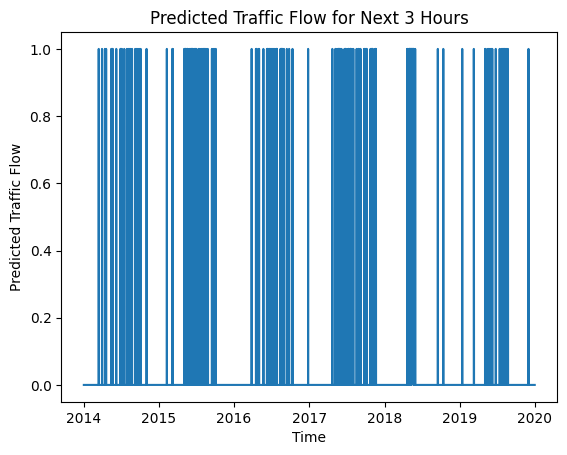

In [ ]:
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas DataFrame
predictions_pd = predictions.select("Date", "prediction").toPandas()


import matplotlib.pyplot as plt
plt.plot(predictions_pd["Date"], predictions_pd["prediction"])
plt.xlabel("Time")
plt.ylabel("Predicted Traffic Flow")
plt.title("Predicted Traffic Flow for Next 3 Hours")
plt.show()

+-----------------+-----+---+
|Anomaly_3hr_Ahead|  0.0|1.0|
+-----------------+-----+---+
|              0.0|10421| 68|
|              1.0|   35| 56|
+-----------------+-----+---+



In [ ]:
spark.setLogLevel("DEBUG")

AttributeError: 'SparkSession' object has no attribute 'setLogLevel'

In [68]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col

predictions = predictions.na.drop(subset=["prediction", "Anomaly_3hr_Ahead"])
predictions = predictions.withColumn("prediction", col("prediction").cast("double"))
predictions = predictions.withColumn("Anomaly_3hr_Ahead", col("Anomaly_3hr_Ahead").cast("double"))

prediction_and_labels = predictions.select("prediction", "Anomaly_3hr_Ahead") \
    .rdd.map(lambda row: (float(row["prediction"]), float(row["Anomaly_3hr_Ahead"])))

print(prediction_and_labels.take(5))  # Fetch 5 rows

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 6178.0 failed 1 times, most recent failure: Lost task 0.0 in stage 6178.0 (TID 3910) (192.168.1.105 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:698)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:663)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:639)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:585)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:543)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 17 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:181)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:698)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:663)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:639)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:585)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:543)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 17 more


In [65]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col

predictions = predictions.na.drop(subset=["prediction", "Anomaly_3hr_Ahead"])
predictions = predictions.na.drop(subset=["prediction", "Anomaly_3hr_Ahead"])
print(f"Total rows after dropping nulls: {predictions.count()}")

predictions = predictions.withColumn("prediction", col("prediction").cast("double"))
predictions = predictions.withColumn("Anomaly_3hr_Ahead", col("Anomaly_3hr_Ahead").cast("double"))
# predictions = predictions.withColumn("")
# Convert predictions to RDD format for MulticlassMetrics
prediction_and_labels = predictions.select("prediction", "Anomaly_3hr_Ahead") \
    .rdd.map(lambda row: (float(row["prediction"]), float(row["Anomaly_3hr_Ahead"])))
predictions.printSchema()
prediction_and_labels.map(lambda x: x).take(5)  # Fetch 5 rows

print(prediction_and_labels)
if prediction_and_labels.count() == 0:
    print("RDD is empty! Check your predictions DataFrame.")
else:
    print(f"RDD contains {prediction_and_labels.count()} records.")

print(f"Total rows in predictions: {predictions.count()}")
print(f"Total rows in RDD: {prediction_and_labels.count()}")

print(prediction_and_labels.count())  # Should be greater than 0
print(prediction_and_labels.take(5))  # Inspect first 5 rows


# Compute confusion matrix
metrics = MulticlassMetrics(prediction_and_labels)
print("Confusion Matrix:")
print(metrics.confusionMatrix().toArray())


Total rows after dropping nulls: 10580
root
 |-- Date: timestamp (nullable = true)
 |-- BGT North of NE 70th Total: double (nullable = false)
 |-- Ped South: double (nullable = false)
 |-- Ped North: double (nullable = false)
 |-- Bike North: double (nullable = false)
 |-- Bike South: double (nullable = false)
 |-- Anomaly: integer (nullable = false)
 |-- Anomaly_3hr_Ahead: double (nullable = true)
 |-- Lag_1_day: double (nullable = false)
 |-- Lag_2_day: double (nullable = false)
 |-- Lag_3_day: double (nullable = false)
 |-- Rolling_Mean_3H: double (nullable = false)
 |-- Rolling_Std_3H: double (nullable = false)
 |-- Bike_Ped_Ratio: double (nullable = false)
 |-- class_weight: double (nullable = false)
 |-- features1: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 6169.0 failed 1 times, most recent failure: Lost task 0.0 in stage 6169.0 (TID 3904) (192.168.1.105 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:698)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:663)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:639)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:585)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:543)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 17 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:181)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:698)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:663)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:639)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:585)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:543)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 17 more


## Backup

In [ ]:
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Separate features and target
X = df.drop("target_3hr", axis=1)
y = df["target_3hr"]

# Impute missing values with the mean (or use "median", "most_frequent", etc.)
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_imputed, y)

# Combine back into DataFrame
resampled_df = pd.concat([
    pd.DataFrame(X_resampled, columns=X.columns),
    pd.Series(y_resampled, name="target_3hr")
], axis=1)
